# Predicting Movie Success

In [1]:
import pandas as pd
import numpy as np
import re # imports regular expressions
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from scipy.stats import chi2_contingency, mannwhitneyu

# Cleaning and Extracting the Data

In [2]:
# CLEANING THE IMDB DATAFRAME
pd.set_option('display.max_colwidth', -1) # Will not truncate the dataframe columns
imdb = pd.read_json('omdb-data.json.gz', orient='record', lines=True, encoding="utf8")

# If omdb_awards = N/A (ie no awards), set it to 0
imdb.loc[imdb['omdb_awards'] == 'N/A', 'omdb_awards'] = 0

# Since omdb_awards is not very consistent in how it displays the data, and not all of the data tells the name of the award,
# we will instead sum the number of awards and nominations, as I believe that the data is still important, although being
# inconsistlenty presented

# Gets total number of awards and nominations
def get_awards(string):
        string = str(string) # convert input to string if not already so that we can use regex
        numbers = re.findall(r'[0-9]+', string) # find all the digits in the string
        numbers = list(map(int, numbers)) # convert the list of strings to ints
        return sum(numbers)
imdb['omdb_awards_sum'] = imdb['omdb_awards'].apply(get_awards)

# Re-ordering columns
imdb = imdb[['omdb_awards', 'omdb_awards_sum', 'omdb_plot', 'omdb_genres', 'imdb_id']] 

# TODO: Natural language processing here if needed

# Show the table
#imdb

In [3]:
# The rotten tomatoes dataframe does not require and cleaning
rotten_tomatoes = pd.read_json('rotten-tomatoes.json.gz', orient='record', lines=True, encoding="utf8")
#rotten_tomatoes

In [4]:
# CLEANING THE WIKIDATA DATAFRAME
wikidata = pd.read_json('wikidata-movies.json.gz', orient='record', lines=True, encoding="utf8")

# The number of cast members and filming locations may be important as it gives an idea of the production value of a film,
# so we calcualte those values
def get_totals(string):
        string = str(string) # convert input to string if not already so that we can use regex
        numbers = re.findall(r'[0-9]+', string) # find all the digits (ids) in the string
        return len(numbers) # return the number of ids found
wikidata['cast_members_total'] = wikidata['cast_member'].apply(get_totals)
wikidata['filming_location_total'] = wikidata['filming_location'].apply(get_totals)

# Re-ordering columns
wikidata = wikidata[['label', 'enwiki_title', 'director', 'cast_member', 'cast_members_total', 'filming_location', 
                     'filming_location_total', 'genre', 'main_subject', 'publication_date', 'made_profit', 'based_on', 
                     'country_of_origin','original_language', 'wikidata_id', 'imdb_id','metacritic_id', 'rotten_tomatoes_id']] 
# Show the table
#wikidata

#wikidata


# Note: Previously I dropped columns here that I did not find useful and the dropped nulls, however doing so resulted in very
# little data being left (only 24 rows). So we will drop nulls and columns when need be according to the question.

# Does Positive Reception with Critics relate to Movie Success (profits)?

In [5]:
profits = wikidata.copy()
profits = profits.drop(columns = ['director', 'cast_member', 'genre', 'cast_members_total', 'filming_location', 
                                'filming_location_total', 'label', 'main_subject', 'publication_date',
                                'based_on', 'country_of_origin', 'original_language', 'imdb_id', 'metacritic_id',
                                'wikidata_id'])
profits = profits.dropna()
profits['made_profit'] = profits['made_profit'].replace({0.0: 'No Profit', 1.0: 'Profit'})


critic = rotten_tomatoes.copy()
critic = critic.drop(columns=['imdb_id'])
critic['audience_average'] = critic['audience_average'].apply(lambda x: x*2)
critic = critic.dropna()
audience = rotten_tomatoes.copy()
audience = audience.drop(columns=['critic_average','audience_ratings', 'critic_percent', 'imdb_id'])
audience['audience_average'] = audience['audience_average'].apply(lambda x: x*2)
audience = audience.dropna()

critic_profits = pd.merge(profits, critic, on='rotten_tomatoes_id', how='inner')
audience_profits = pd.merge(profits, audience, on='rotten_tomatoes_id', how='inner')

critic_profits = critic_profits.dropna()
audience_profits = audience_profits.dropna()

critic_profits = critic_profits.reset_index().drop(columns=['index', 'rotten_tomatoes_id'])
audience_profits = audience_profits.reset_index().drop(columns=['index', 'rotten_tomatoes_id'])


reviews = critic_profits.copy()
reviews['critic_percent'] = critic_profits['critic_percent'] >= 60.0
reviews['audience_percent'] = critic_profits['audience_percent'] >= 60.0
reviews['critic_percent'] = reviews['critic_percent'].replace({False: 'Negative', True: 'Positive'})
reviews['audience_percent'] = reviews['audience_percent'].replace({False: 'Negative', True: 'Positive'})
reviews['made_profit'] = reviews['made_profit'].replace({0.0: 'No Profit', 1.0: 'Made Profit'})

critic_reception = pd.crosstab(reviews['critic_percent'],reviews['made_profit'])
critic_reception

made_profit,No Profit,Profit
critic_percent,,
Negative,62,212
Positive,49,413


In [6]:
chi2, instr_p, dof, expected = chi2_contingency(critic_reception)
instr_p

1.715693351969996e-05

In [7]:
audience_reception = pd.crosstab(reviews['audience_percent'],reviews['made_profit'])
audience_reception

made_profit,No Profit,Profit
audience_percent,,
Negative,64,179
Positive,47,446


In [8]:
chi2, instr_p, dof, expected = chi2_contingency(audience_reception)
instr_p

4.073781499531377e-09

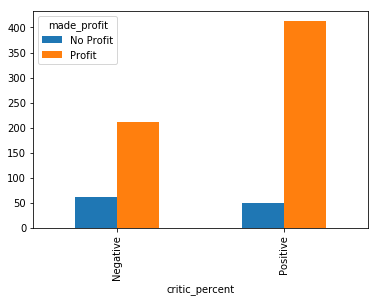

In [9]:
critic_reception.plot.bar()
plt.show()

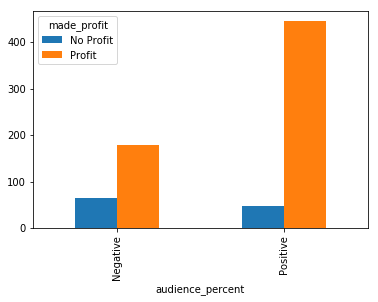

In [10]:
audience_reception.plot.bar()
plt.show()

# Are Audiences more generous than critics for popular movies?

In [11]:
critic_profits['Audience_more_positive?'] = critic_profits['audience_percent'] >= critic_profits['critic_percent']
critic_profits['Critical_Acclaim'] = critic_profits['critic_percent'] > 75.0
critic_profits['Critical_reception'] = critic_profits['critic_percent'] > 60.0 
critic_profits['Audience_reception'] = critic_profits['audience_percent'] >= 80.0
critic_profits['Critical_reception'] = critic_profits['Critical_reception'].replace({False: 'Negative', True: 'Positive'})
critic_profits['Audience_reception'] = critic_profits['Audience_reception'].replace({False: '<80', True: '>= 80'})
critic_profits['Popularity'] = critic_profits['audience_ratings'] >= 150000.0
critic_profits['Popularity'] = critic_profits['Popularity'].replace({False: 'Not Popular (<150000)', True: 'Popular (>=50000)'})
critic_profits

,enwiki_title,made_profit,audience_average,audience_percent,audience_ratings,critic_average,critic_percent,Audience_more_positive?,Critical_Acclaim,Critical_reception,Audience_reception,Popularity
0,Orbiter 9,No Profit,6.2,41.0,60.0,5.5,60.0,False,False,Negative,<80,Not Popular (<150000)
1,Eraserhead,Profit,7.8,83.0,57175.0,8.3,91.0,False,True,Positive,>= 80,Not Popular (<150000)
2,Dances with Wolves,Profit,7.2,87.0,213360.0,7.5,82.0,True,True,Positive,>= 80,Popular (>=50000)
3,Inception,Profit,8.4,91.0,568239.0,8.1,86.0,True,True,Positive,>= 80,Popular (>=50000)
4,Mama (2013 film),Profit,6.8,55.0,143566.0,6.0,65.0,False,False,Positive,<80,Not Popular (<150000)
5,The Godfather,Profit,8.8,98.0,731426.0,9.3,98.0,True,True,Positive,>= 80,Popular (>=50000)
6,Argo (2012 film),Profit,8.4,90.0,207900.0,8.4,96.0,False,True,Positive,>= 80,Popular (>=50000)
7,12 Years a Slave (film),Profit,8.6,90.0,139374.0,8.9,96.0,False,True,Positive,>= 80,Not Popular (<150000)
8,Only Lovers Left Alive,Profit,7.6,75.0,21114.0,7.4,85.0,False,True,Positive,<80,Not Popular (<150000)
9,The Hunger Games: Mockingjay – Part 1,Profit,7.6,71.0,246430.0,6.3,67.0,True,False,Positive,<80,Popular (>=50000)


In [12]:
Popular_audience = pd.crosstab(critic_profits['Popularity'], critic_profits['Audience_reception'])
Popular_audience

Audience_reception,<80,>= 80
Popularity,,
Not Popular (<150000),311,128
Popular (>=50000),155,142


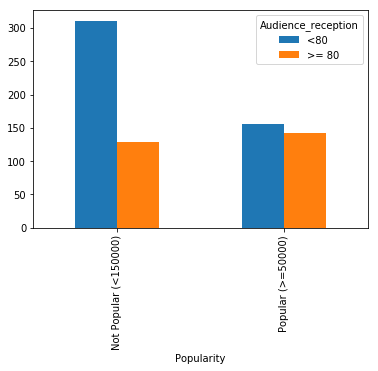

In [13]:
Popular_audience.plot.bar()
plt.show()

In [14]:
chi2, instr_p, dof, expected = chi2_contingency(Popular_audience)
instr_p


3.8999003915515213e-07

In [15]:
acclaim_audience = pd.crosstab(critic_profits['Critical_Acclaim'], critic_profits['Audience_more_positive?'])
chi2, instr_p, dof, expected = chi2_contingency(acclaim_audience)
instr_p

6.32620594099585e-36

In [16]:

acclaim_audience = pd.crosstab(critic_profits['Critical_Acclaim'], critic_profits['Audience_more_positive?'])
acclaim_audience

Audience_more_positive?,False,True
Critical_Acclaim,,
False,104,301
True,239,92


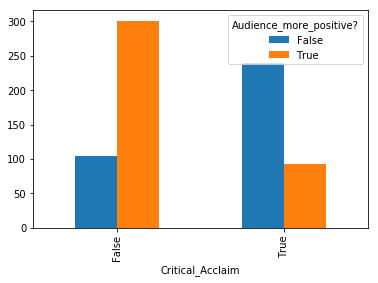

In [17]:
acclaim_audience.plot.bar()
plt.show()

In [18]:
critic_profits['Popularity'] = critic_profits['audience_ratings'] >= 100000.0
acclaim_popularity = pd.crosstab(critic_profits['Critical_reception'], critic_profits['Popularity'])
acclaim_popularity

Popularity,False,True
Critical_reception,,
Negative,167,117
Positive,194,258


In [19]:
chi2, instr_p, dof, expected = chi2_contingency(acclaim_popularity)
instr_p

3.787454069220839e-05

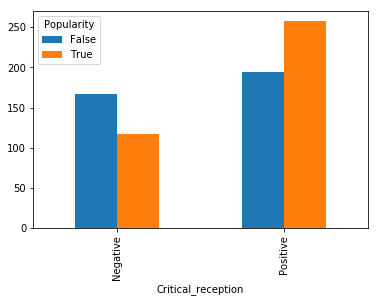

In [20]:
acclaim_popularity.plot.bar()
plt.show()

In [21]:
critic_profits['Audience_reception'] = critic_profits['audience_percent'] >75.0
critic_profits['Audience_reception'] = critic_profits['Audience_reception'].replace({False: 'Negative', True: 'Positive'})
critics_audience = pd.crosstab(critic_profits['Critical_reception'], critic_profits['Audience_reception'])
critics_audience

Audience_reception,Negative,Positive
Critical_reception,,
Negative,268,16
Positive,139,313


In [22]:
chi2, instr_p, dof, expected = chi2_contingency(critics_audience)
instr_p

1.6997608466590702e-63

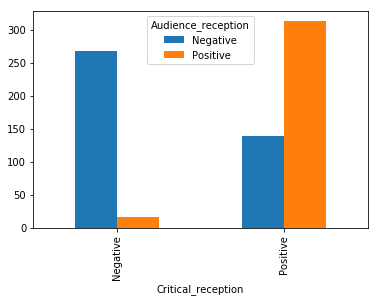

In [23]:
critics_audience.plot.bar()
plt.show()

In [24]:
stats.pearsonr(critic_profits['critic_average'], critic_profits['audience_average'])

(0.7376616217797226, 2.4553714477112174e-127)

In [25]:
stats.pearsonr(critic_profits['critic_percent'], critic_profits['audience_percent'])

(0.806375177098194, 1.3344721989346667e-169)